In [1]:
!python ../src/utils.py

In [2]:
# %load_ext autoreload
# %autoreload 2
%reload_ext autoreload

In [3]:

import os
import math
import ROOT as rt
import numpy as np
import matplotlib.pyplot as plt
import utils 
from ROOT import VecOps
from analysis import (df, df_filtered, tree, HMNCSBR, TRUNCSBR, COLOR_MAP)

name_tag = str(utils.TAG)
print("cwd:", os.getcwd())


cwd: /home/bothsides/projects/optimizing_DEDx_estimator/notebooks


In [4]:
drawer = utils.HistogramDrawer() 

In [5]:
output_root = utils.OUTPUT_ROOT
plots_dir   = utils.PLOTS_DIR

#just making sure the dirs actually exist
os.makedirs(output_root, exist_ok=True)
os.makedirs(plots_dir,   exist_ok=True)

#creates a root file to save our histogram objects
# remember to f_out.Close() -> this does the writing of the objects to the file
f_out = rt.TFile(f"{output_root}/all_histos.root", "UPDATE") 

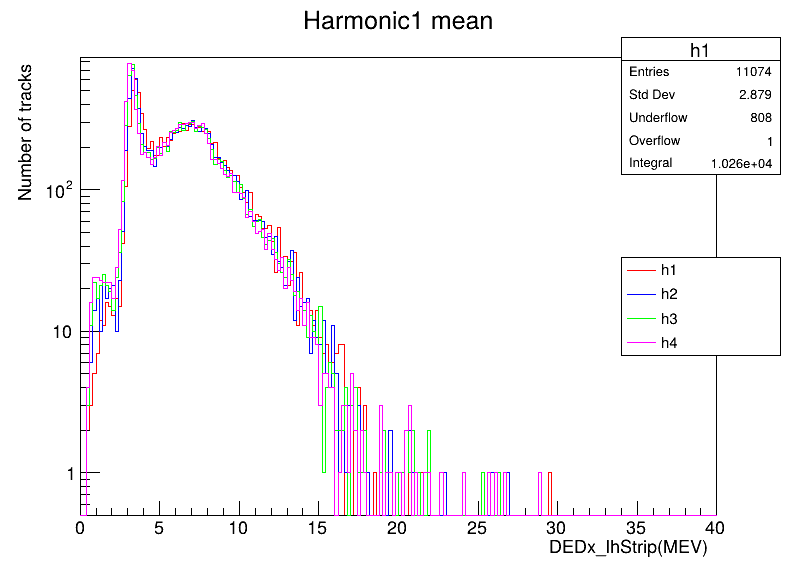

In [6]:



c = rt.TCanvas("h2_canvas_overlay","Log-scale overlay",800,600)
c.SetLogy()

leg = rt.TLegend(0.78,0.38,0.98,0.55)

hists = {} # dictionary to hold histogram names for harmonic2 DEDx track avergaes plot

for i, branch in enumerate(HMNCSBR):
    hists[f"h{i+1}"] = df.Histo1D((f"h{i+1}","",200, 0, 40),branch)
    hists[f"h{i+1}"].SetLineColor(COLOR_MAP[i+1])
    rt.gStyle.SetOptStat("neiuor") 
    leg.AddEntry( hists[f"h{i+1}"].GetPtr(), f"h{i+1}", "l" )
    hists[f"h{i+1}"].SetTitle(f"Harmonic{i+1} mean")
    hists[f"h{i+1}"].GetXaxis().SetTitle("DEDx_lhStrip(MEV)")
    hists[f"h{i+1}"].GetYaxis().SetTitle("Number of tracks")
    hists[f"h{i+1}"].Draw("same")
    
max_vals = [h.GetMaximum() for h in hists.values()]
overall_max = max(max_vals)
hists["h1"].SetMaximum(overall_max * 1.1)


leg.Draw()

c.Draw()


# utils.write_stacked_histos_ptr("h2_overlay", hists, "harmonic means", c)

# # building a histogram stack and writing to the root file f_out points to

# stack = rt.THStack("h2_overlay", "Generalized harmonic means")

# for proxy in hists.values():
#     stack.Add(proxy.GetPtr()) #pyroot stores a pointer in the dictionary, I need to pull that out
    
# stack.Write()
# c.Write()

In [7]:
print(hists.values())

dict_values([<cppyy.gbl.ROOT.RDF.RResultPtr<TH1D> object at 0x15e487a0>, <cppyy.gbl.ROOT.RDF.RResultPtr<TH1D> object at 0x18b4cd90>, <cppyy.gbl.ROOT.RDF.RResultPtr<TH1D> object at 0x18a64ad0>, <cppyy.gbl.ROOT.RDF.RResultPtr<TH1D> object at 0x18d46e80>])


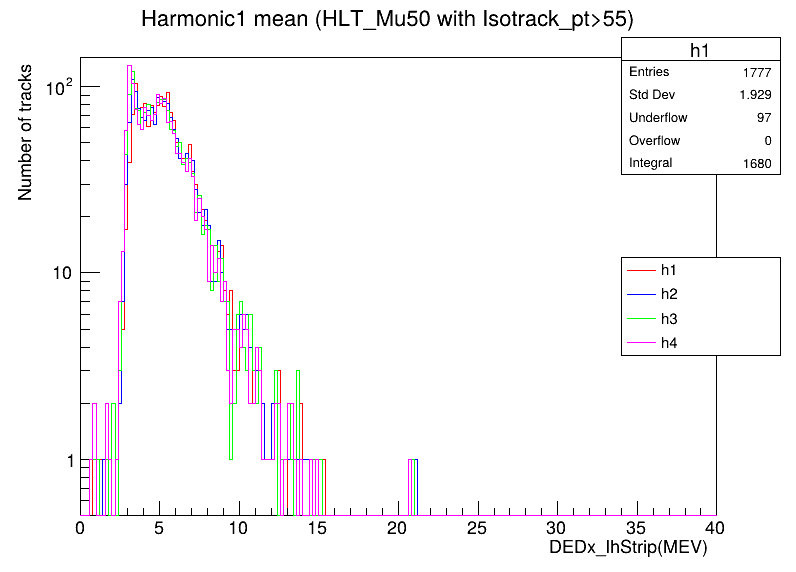

In [8]:

c = rt.TCanvas("h2_filtered_canvas_overlay","Log-scale overlay",800,600)
c.SetLogy()

leg = rt.TLegend(0.78,0.38,0.98,0.55)

hists = {} # dictionary to hold histogram names for harmonic2 DEDx track avergaes plot

for i, branch in enumerate(HMNCSBR):
    hists[f"h{i+1}"] = df_filtered.Histo1D((f"h{i+1}","",200, 0, 40),branch)
    hists[f"h{i+1}"].SetLineColor(COLOR_MAP[i+1])
    rt.gStyle.SetOptStat("neiuor") 
    leg.AddEntry( hists[f"h{i+1}"].GetPtr(), f"h{i+1}", "l" )
    hists[f"h{i+1}"].SetTitle(f"Harmonic{i+1} mean (HLT_Mu50 with Isotrack_pt>55)")
    hists[f"h{i+1}"].GetXaxis().SetTitle("DEDx_lhStrip(MEV)")
    hists[f"h{i+1}"].GetYaxis().SetTitle("Number of tracks")
    hists[f"h{i+1}"].Draw("same")
    
max_vals = [h.GetMaximum() for h in hists.values()]
overall_max = max(max_vals)
hists["h1"].SetMaximum(overall_max * 1.1)


leg.Draw()

c.Draw()

# utils.write_stacked_histos_ptr("h2_filtered_overlay", hists, "harmonic means filtered", c) 

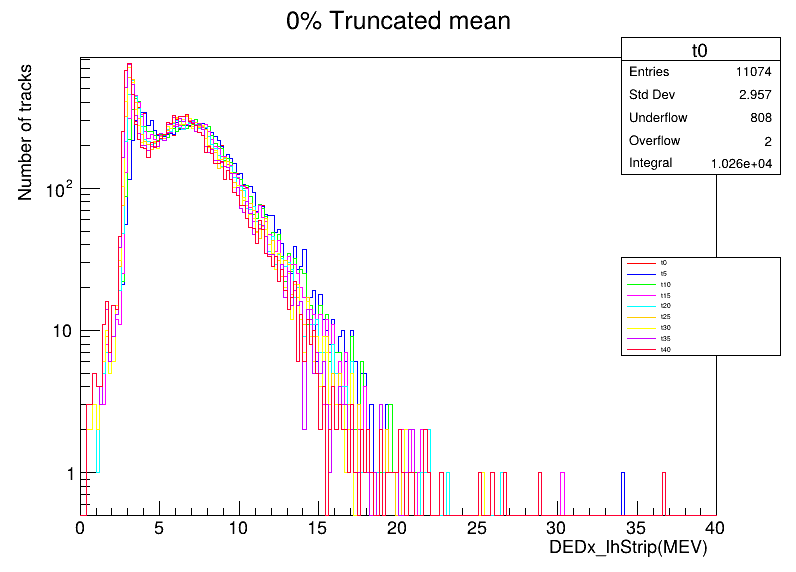

In [9]:

c = rt.TCanvas("Trunc_overlay_canvas","Log-scale overlay",800,600)
c.SetLogy()

leg = rt.TLegend(0.78,0.38,0.98,0.55)

hists = {} # dictionary to hold histogram names for truncated DEDx track avergaes plot


for i, branch in enumerate(TRUNCSBR):
    hists[f"t{5*i}"] = df.Histo1D((f"t{5*i}","",200, 0, 40),branch)
    hists[f"t{5*i}"].SetLineColor(COLOR_MAP[i+1])
    rt.gStyle.SetOptStat("neiuor") 
    leg.AddEntry( hists[f"t{5*i}"].GetPtr(), f"t{5*i}", "l" )
    hists[f"t{5*i}"].SetTitle(f"{5*i}% Truncated mean")
    hists[f"t{5*i}"].GetXaxis().SetTitle("DEDx_lhStrip(MEV)")
    hists[f"t{5*i}"].GetYaxis().SetTitle("Number of tracks")
    hists[f"t{5*i}"].Draw("same")

max_vals = [h.GetMaximum() for h in hists.values()]
overall_max = max(max_vals)
hists["t0"].SetMaximum(overall_max * 1.1)

leg.Draw()
c.Draw()

# utils.write_stacked_histos_ptr("Trunc_overlay", hists, "Truncated means", c)

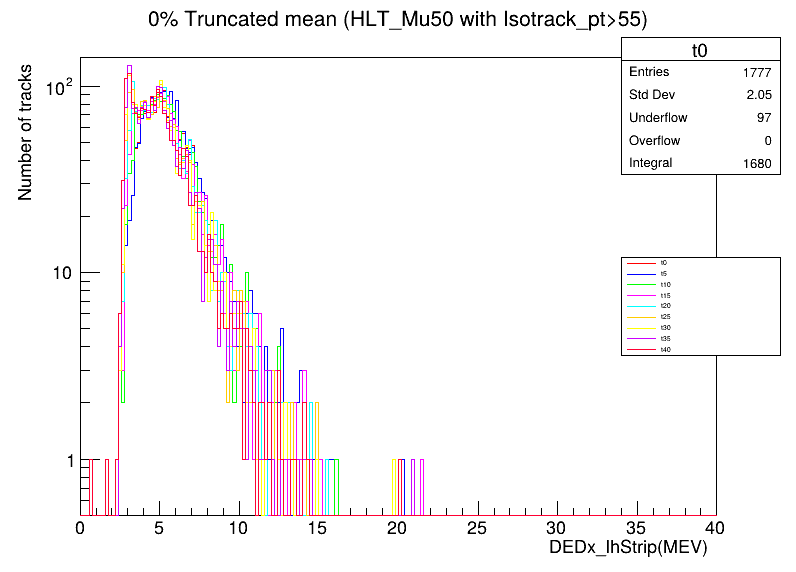

In [10]:

c = rt.TCanvas("Trunc_filtered_overlay_canvas","Log-scale overlay",800,600)
c.SetLogy()

leg = rt.TLegend(0.78,0.38,0.98,0.55)

hists = {} # dictionary to hold histogram names for truncated DEDx track avergaes plot

for i, branch in enumerate(TRUNCSBR):
    hists[f"t{5*i}"] = df_filtered.Histo1D((f"t{5*i}","",200, 0, 40),branch)
    hists[f"t{5*i}"].SetLineColor(COLOR_MAP[i+1])
    rt.gStyle.SetOptStat("neiuor") 
    leg.AddEntry( hists[f"t{5*i}"].GetPtr(), f"t{5*i}", "l" )
    hists[f"t{5*i}"].SetTitle(f"{5*i}% Truncated mean (HLT_Mu50 with Isotrack_pt>55)")
    hists[f"t{5*i}"].GetXaxis().SetTitle("DEDx_lhStrip(MEV)")
    hists[f"t{5*i}"].GetYaxis().SetTitle("Number of tracks")
    hists[f"t{5*i}"].Draw("same")

max_vals = [h.GetMaximum() for h in hists.values()]
overall_max = max(max_vals)
hists["t0"].SetMaximum(overall_max * 1.1)

leg.Draw()
c.Draw()

# utils.write_stacked_histos_ptr("Trunc_filtered_overlay", hists, "Truncated mean filtered", c)

In [11]:
#TODO: each histogram for each categorized mean, overlaid with it's filtered component, with their ratio and all 

In [12]:
f_out.Close()

In [13]:
f = rt.TFile(f"{output_root}/all_histos.root") #opens up the root file for reading

!rootls -t ../output/root/all_histos.root

TCanvas  Jul 15 23:24 2025 h2_canvas_overlay;1             "Log-scale overlay" 
TCanvas  Jul 15 23:24 2025 h2_filtered_canvas_overlay;1    "Log-scale overlay" 
THStack  Jul 15 23:24 2025 h2_filtered_overlay;1           "harmonic means filtered" 
THStack  Jul 15 23:24 2025 h2_overlay;1                    "harmonic means" 
THStack  Jul 15 23:24 2025 Trunc_filtered_overlay;1        "Truncated mean filtered" 
TCanvas  Jul 15 23:24 2025 Trunc_filtered_overlay_canvas;1 "Log-scale overlay" 
THStack  Jul 15 23:24 2025 Trunc_overlay;1                 "Truncated means" 
TCanvas  Jul 15 23:24 2025 Trunc_overlay_canvas;1          "Log-scale overlay" 


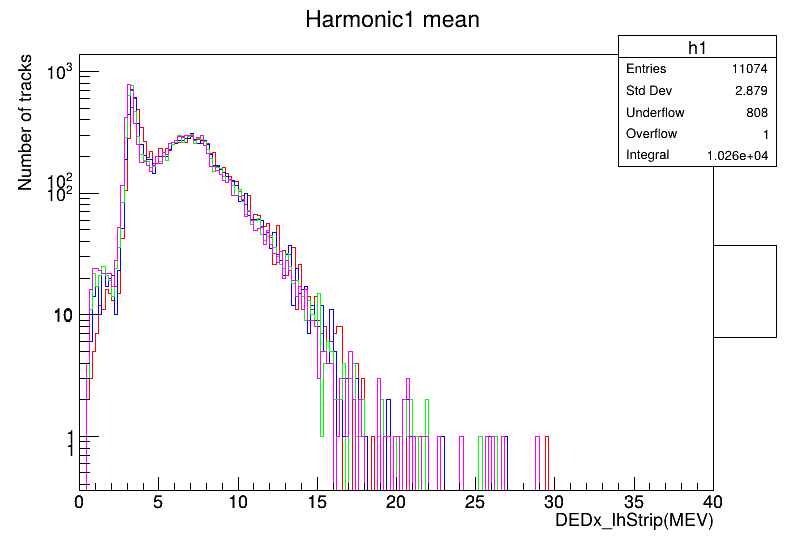

In [14]:
h2_stack = f.Get("h2_overlay")
c = f.Get("h2_canvas_overlay")

h2_stack.Draw("nostack")
c.Draw()

In [15]:
h2_stack = f.Get("h2_overlay")
h2_canvas = f.Get("h2_canvas_overlay")
h2_hist_list = h2_stack.GetHists()


h2_filtered_stack = f.Get("h2_filtered_overlay")
h2_filtered_canvas = f.Get("h2_filtered_canvas_overlay")
h2_filtered_hist_list = h2_filtered_stack.GetHists()


trunc_stack = f.Get("Trunc_overlay")
trunc_canvas = f.Get("Trunc_overlay_canvas")
trunc_hist_list = trunc_stack.GetHists()


trunc_filtered_stack = f.Get("Trunc_filtered_overlay")
trunc_filtered_canvas = f.Get("Trunc_filtered_overlay_canvas")
trunc_filtered_hist_list = trunc_filtered_stack.GetHists()

In [16]:
# #you have your two TH1*s to be overlaid
# h_num = h2_hist_list.At(0)
# h_den = h2_hist_list.At(3)


In [17]:
# %jsroot

# def draw_two_ratio(h_num: rt.TH1, h_den: rt.TH1, 
#                    option: str="pois", 
#                    canvas_name: str="ratio", 
#                    title: str="") -> rt.TCanvas:
#     c = rt.TCanvas(canvas_name
# , title or canvas_name, 800,600)
#     rp = rt.TRatioPlot(h_num, h_den, option)
#     rp.Draw()
#     c.Update()
#     return rp
  
# h = draw_two_ratio(h_num, h_den)


In [18]:
# c = rt.TCanvas()
# h.Draw()
# c.Draw()

In [19]:
%jsroot on

drawer = utils.HistogramDrawer()
# a = drawer.draw_two_ratio(h_num, h_den)

In [20]:
# # close any existing canvases so ROOT will make a truly new one
# for canv in rt.gROOT.GetListOfCanvases():
#     canv.Close()


# # 1) make your canvas
# c = rt.TCanvas("c_ratio","Ratio Plot", 800, 800)

# #create two pads: top (0.3–1) and bottom (0–0.3)
# pad1 = rt.TPad("pad1", "Top pad", 0, 0.3, 1, 1)
# pad2 = rt.TPad("pad2","Bottom pad", 0, 0,   1, 0.3)
# pad1.SetBottomMargin(0)   # no x-axis tick labels
# pad2.SetTopMargin(0.02)      # no title overlap
# pad2.SetBottomMargin(0.4)    # room for x-axis label
# pad1.Draw(); pad2.Draw()

# #draw your two histos in pad1
# pad1.cd()
# pad1.SetLogy(1)              # if you want log-Y in the top
# h_den.SetLineColor(rt.kBlack)
# h_num.SetLineColor(rt.kRed)
# # auto-scale so they both fit
# maxval = max(h_den.GetMaximum(), h_num.GetMaximum())
# h_den.SetMaximum(maxval*1.2)
# h_den.SetTitle(f"Title")
# h_den.GetYaxis().SetTitle("Number of tracks")
# h_den.Draw()
# h_num.Draw("same")
# pad1.Update()


# #build the ratio histogram in pad2
# pad2.cd()
# ratio = h_num.Clone("ratio")       # clone numerator
# ratio.Divide(h_den)                # divide by denominator
# ratio.SetMarkerStyle(20)           # draw as points
# ratio.SetTitle("")                 # no global title
# ratio.GetYaxis().SetTitle("Num/Den")
# ratio.GetXaxis().SetTitle("DEDx_IhStrip (MeV/cm)")
# # tweak axis label sizes so they’re big in the small pad:
# ratio.GetYaxis().SetTitleSize(0.05)
# ratio.GetYaxis().SetTitleOffset(0.4)
# ratio.GetYaxis().SetLabelSize(0.05)
# ratio.GetXaxis().SetTitleSize(0.08)
# ratio.GetXaxis().SetLabelSize(0.08)

# # set a sensible ratio range, e.g. 0.5–1.5
# ratio.SetMinimum(-5)
# ratio.SetMaximum(5)
# ratio.Draw("EP")                   # E: error bars, P: points
# pad2.Update()


# #finally draw the overall canvas
# c.cd()
# c.Modified()
# c.Draw()

In [21]:


N =  h2_hist_list.GetSize()
M = trunc_hist_list.GetSize()

In [22]:
cols = 2
rows = math.ceil(N/cols)

c = rt.TCanvas("c_all", "All Histograms", cols*800, rows*800)
c.Divide(cols, rows)

for i in range(N):
    pad = c.cd(i+1)
    pad.SetLogy(1)
    hist = h2_hist_list.At(i)
    hist_fltrd = h2_filtered_hist_list.At(i)
    
    hist.SetTitle(f"harmonic mean (with harmonic power = -{i+1})")
    
    hist.SetLineColor(rt.kRed)
    hist_fltrd.SetLineColor(rt.kBlack)
    
    hist.GetXaxis().SetTitle("DEDX_IhStrip(MEV/cm)")
    hist.GetYaxis().SetTitle("Number of tracks")
    
    maxval = max(hist.GetMaximum(), hist_fltrd.GetMaximum())
    hist.SetMaximum(maxval * 1.2)
    
    # Enable statistics box with entries and standard deviation
    rt.gStyle.SetOptStat("ner")  # n=entries, r=RMS/standard deviation
    hist.Draw("hist")
    hist_fltrd.Draw("hist same")  # Draw filtered histogram overlay
    
    # Add legend to each pad (create new legend for each iteration)
    pad.cd()  # Make sure we're in the correct pad
    leg = rt.TLegend(0.6, 0.7, 0.9, 0.9)
    leg.SetBorderSize(0)  # Remove legend border
    leg.SetFillStyle(0)   # Make legend background transparent
    leg.AddEntry(hist, "Unfiltered", "l")
    leg.AddEntry(hist_fltrd, "Filtered (HLT_Mu50, pt>55)", "l")
    leg.Draw()
    
c.Modified()
c.Draw()

In [23]:
drawer.save(c, f"{utils.PLOTS_DIR}/all_harmonic_estimators(with filtered)",["png"])

Info in <TCanvas::Print>: png file ../output/plots/all_harmonic_estimators(with filtered).png has been created


In [24]:
cols = 4
rows = math.ceil(M/cols)

c = rt.TCanvas("c_all", "All Histograms", cols*800, rows*800)
c.Divide(cols, rows)

for i in range(M):
    pad = c.cd(i+1)
    pad.SetLogy(1)
    hist = trunc_hist_list.At(i)
    hist_fltrd = trunc_filtered_hist_list.At(i)
    
    hist.SetTitle(f"Truncated mean (last {i*5}% truncation)")
    hist.SetLineColor(rt.kRed)
    hist_fltrd.SetLineColor(rt.kBlack)
    
    hist.GetXaxis().SetTitle("DEDX_ItStrip(MEV/cm)")
    hist.GetYaxis().SetTitle("Number of tracks")
    
    maxval = max(hist.GetMaximum(), hist_fltrd.GetMaximum())
    hist.SetMaximum(maxval * 1.2)
    rt.gStyle.SetOptStat("ner") 
    
    # Draw histograms first
    hist.Draw("hist")
    hist_fltrd.Draw("hist same")  # Draw filtered histogram overlay
    
    # Add legend to each pad (create new legend for each iteration)
    pad.cd()  # Make sure we're in the correct pad
    leg = rt.TLegend(0.6, 0.7, 0.9, 0.9)
    leg.SetBorderSize(0)  # Remove legend border
    leg.SetFillStyle(0)   # Make legend background transparent
    leg.AddEntry(hist, "Unfiltered", "l")
    leg.AddEntry(hist_fltrd, "Filtered (HLT_Mu50, pt>55)", "l")
    leg.Draw()
    
c.Modified()
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_all


In [25]:
drawer.save(c, f"{utils.PLOTS_DIR}/all_trunc_estimators(with filtered)",["png"])

Info in <TCanvas::Print>: png file ../output/plots/all_trunc_estimators(with filtered).png has been created


In [26]:
# f.Close()


In [27]:
# closing the root file
#f_out.Close()

# Individual Estimator Histograms

This section shows individual histograms for each harmonic mean and truncated mean estimator, comparing filtered vs unfiltered data.

In [28]:
# Harmonic-1 Mean (Arithmetic Mean)
c = rt.TCanvas("h1_canvas", "Harmonic-1 Mean", 800, 600)
c.SetLogy()

# Get histograms from the loaded stacks
h1_unfiltered = h2_hist_list.At(0)  # First harmonic mean

# Style the histograms
h1_unfiltered.SetLineColor(rt.kRed)

# Set titles and labels
h1_unfiltered.SetTitle("Harmonic-1 Mean")
h1_unfiltered.GetXaxis().SetTitle("dE/dx (MeV/cm)")
h1_unfiltered.GetYaxis().SetTitle("Number of tracks")

# Draw histograms
rt.gStyle.SetOptStat(0)
h1_unfiltered.Draw("hist")

c.Draw()

# Save the plot
# drawer.save(c, f"{utils.PLOTS_DIR}/harmonic1_mean",["png"])

# Individual harmonic1_mean estimator histogram (unfiltered)
c = rt.TCanvas("c_harmonic1_mean", "Harmonic 1 Mean Histogram", 800, 600)
h1_unfiltered.SetTitle("Harmonic 1 Mean Estimator (Unfiltered)")
h1_unfiltered.GetYaxis().SetTitle("Number of tracks")
h1_unfiltered.Draw()
c.Draw()
# drawer.save(c, f"{utils.PLOTS_DIR}/harmonic1_mean_histogram", ["png"])

In [29]:
# Harmonic-2 Mean
c = rt.TCanvas("h2_canvas", "Harmonic-2 Mean", 800, 600)
c.SetLogy()

# Get histograms from the loaded stacks
h2_unfiltered = h2_hist_list.At(1)  # Second harmonic mean

# Style the histograms
h2_unfiltered.SetLineColor(rt.kRed)

# Set titles and labels
h2_unfiltered.SetTitle("Harmonic-2 Mean")
h2_unfiltered.GetXaxis().SetTitle("dE/dx (MeV/cm)")
h2_unfiltered.GetYaxis().SetTitle("Number of tracks")

# Draw histograms
rt.gStyle.SetOptStat(0)
h2_unfiltered.Draw("hist")

c.Draw()

# Save the plot
# drawer.save(c, f"{utils.PLOTS_DIR}/harmonic2_mean",["png"])

# Individual harmonic2_mean estimator histogram (unfiltered)
c = rt.TCanvas("c_harmonic2_mean", "Harmonic 2 Mean Histogram", 800, 600)
h2_unfiltered.SetTitle("Harmonic 2 Mean Estimator (Unfiltered)")
h2_unfiltered.GetYaxis().SetTitle("Number of tracks")
h2_unfiltered.Draw()
c.Draw()
# drawer.save(c, f"{utils.PLOTS_DIR}/harmonic2_mean_histogram", ["png"])

In [30]:
# Harmonic-3 Mean
c = rt.TCanvas("h3_canvas", "Harmonic-3 Mean", 800, 600)
c.SetLogy()

# Get histograms from the loaded stacks
h3_unfiltered = h2_hist_list.At(2)  # Third harmonic mean

# Style the histograms
h3_unfiltered.SetLineColor(rt.kRed)

# Set titles and labels
h3_unfiltered.SetTitle("Harmonic-3 Mean")
h3_unfiltered.GetXaxis().SetTitle("dE/dx (MeV/cm)")
h3_unfiltered.GetYaxis().SetTitle("Number of tracks")

# Draw histograms
rt.gStyle.SetOptStat(0)
h3_unfiltered.Draw("hist")

c.Draw()

# Save the plot
# drawer.save(c, f"{utils.PLOTS_DIR}/harmonic3_mean",["png"])

# Individual harmonic3_mean estimator histogram (unfiltered)
c = rt.TCanvas("c_harmonic3_mean", "Harmonic 3 Mean Histogram", 800, 600)
h3_unfiltered.SetTitle("Harmonic 3 Mean Estimator (Unfiltered)")
h3_unfiltered.GetYaxis().SetTitle("Number of tracks")
h3_unfiltered.Draw()
c.Draw()
# drawer.save(c, f"{utils.PLOTS_DIR}/harmonic3_mean_histogram", ["png"])

In [31]:
# Harmonic-4 Mean
c = rt.TCanvas("h4_canvas", "Harmonic-4 Mean", 800, 600)
c.SetLogy()

# Get histograms from the loaded stacks
h4_unfiltered = h2_hist_list.At(3)  # Fourth harmonic mean

# Style the histograms
h4_unfiltered.SetLineColor(rt.kRed)

# Set titles and labels
h4_unfiltered.SetTitle("Harmonic-4 Mean")
h4_unfiltered.GetXaxis().SetTitle("dE/dx (MeV/cm)")
h4_unfiltered.GetYaxis().SetTitle("Number of tracks")

# Draw histograms
rt.gStyle.SetOptStat(0)
h4_unfiltered.Draw("hist")

c.Draw()

# Save the plot
# drawer.save(c, f"{utils.PLOTS_DIR}/harmonic4_mean",["png"])

# Individual harmonic4_mean estimator histogram (unfiltered)
c = rt.TCanvas("c_harmonic4_mean", "Harmonic 4 Mean Histogram", 800, 600)
h4_unfiltered.SetTitle("Harmonic 4 Mean Estimator (Unfiltered)")
h4_unfiltered.GetYaxis().SetTitle("Number of tracks")
h4_unfiltered.Draw()
c.Draw()
# drawer.save(c, f"{utils.PLOTS_DIR}/harmonic4_mean_histogram", ["png"])

## Truncated Mean Estimators

Individual histograms for each truncated mean estimator (0%, 5%, 10%, 15%, 20%, 25%, 30%, 35%, 40% truncation).

In [32]:
# 0% Truncated Mean (Arithmetic Mean)
c = rt.TCanvas("t0_canvas", "0% Truncated Mean", 800, 600)
c.SetLogy()

# Get histograms from the loaded stacks
t0_unfiltered = trunc_hist_list.At(0)  # 0% truncation

# Style the histograms
t0_unfiltered.SetLineColor(rt.kRed)

# Set titles and labels
t0_unfiltered.SetTitle("0% Truncated Mean (Arithmetic Mean)")
t0_unfiltered.GetXaxis().SetTitle("dE/dx (MeV/cm)")
t0_unfiltered.GetYaxis().SetTitle("Number of tracks")

# Draw histograms
rt.gStyle.SetOptStat(0)
t0_unfiltered.Draw("hist")

c.Draw()

# Save the plot
# drawer.save(c, f"{utils.PLOTS_DIR}/truncated0_mean",["png"])

# Individual truncated0_mean estimator histogram (unfiltered)
c = rt.TCanvas("c_truncated0_mean", "Truncated 0% Mean Histogram", 800, 600)
t0_unfiltered.SetTitle("Truncated 0% Mean Estimator (Unfiltered)")
t0_unfiltered.GetYaxis().SetTitle("Number of tracks")
t0_unfiltered.Draw()
c.Draw()
# drawer.save(c, f"{utils.PLOTS_DIR}/truncated0_mean_histogram", ["png"])

In [33]:
# 5% Truncated Mean
c = rt.TCanvas("t5_canvas", "5% Truncated Mean", 800, 600)
c.SetLogy()

# Get histograms from the loaded stacks
t5_unfiltered = trunc_hist_list.At(1)  # 5% truncation

# Style the histograms
t5_unfiltered.SetLineColor(rt.kRed)

# Set titles and labels
t5_unfiltered.SetTitle("5% Truncated Mean")
t5_unfiltered.GetXaxis().SetTitle("dE/dx (MeV/cm)")
t5_unfiltered.GetYaxis().SetTitle("Number of tracks")

# Draw histograms
rt.gStyle.SetOptStat(0)
t5_unfiltered.Draw("hist")

c.Draw()

# Save the plot
# drawer.save(c, f"{utils.PLOTS_DIR}/truncated5_mean",["png"])

# Individual truncated5_mean estimator histogram (unfiltered)
c = rt.TCanvas("c_truncated5_mean", "Truncated 5% Mean Histogram", 800, 600)
t5_unfiltered.SetTitle("Truncated 5% Mean Estimator (Unfiltered)")
t5_unfiltered.GetYaxis().SetTitle("Number of tracks")
t5_unfiltered.Draw()
c.Draw()
# drawer.save(c, f"{utils.PLOTS_DIR}/truncated5_mean_histogram", ["png"])

In [34]:
# 10% Truncated Mean
c = rt.TCanvas("t10_canvas", "10% Truncated Mean", 800, 600)
c.SetLogy()

# Get histograms from the loaded stacks
t10_unfiltered = trunc_hist_list.At(2)  # 10% truncation

# Style the histograms
t10_unfiltered.SetLineColor(rt.kRed)

# Set titles and labels
t10_unfiltered.SetTitle("10% Truncated Mean")
t10_unfiltered.GetXaxis().SetTitle("dE/dx (MeV/cm)")
t10_unfiltered.GetYaxis().SetTitle("Number of tracks")

# Draw histograms
rt.gStyle.SetOptStat(0)
t10_unfiltered.Draw("hist")

c.Draw()

# Save the plot
# drawer.save(c, f"{utils.PLOTS_DIR}/truncated10_mean",["png"])

# Individual truncated10_mean estimator histogram (unfiltered)
c = rt.TCanvas("c_truncated10_mean", "Truncated 10% Mean Histogram", 800, 600)
t10_unfiltered.SetTitle("Truncated 10% Mean Estimator (Unfiltered)")
t10_unfiltered.GetYaxis().SetTitle("Number of tracks")
t10_unfiltered.Draw()
c.Draw()
# drawer.save(c, f"{utils.PLOTS_DIR}/truncated10_mean_histogram", ["png"])

In [35]:
# 15% Truncated Mean
c = rt.TCanvas("t15_canvas", "15% Truncated Mean", 800, 600)
c.SetLogy()

# Get histograms from the loaded stacks
t15_unfiltered = trunc_hist_list.At(3)  # 15% truncation

# Style the histograms
t15_unfiltered.SetLineColor(rt.kRed)

# Set titles and labels
t15_unfiltered.SetTitle("15% Truncated Mean")
t15_unfiltered.GetXaxis().SetTitle("dE/dx (MeV/cm)")
t15_unfiltered.GetYaxis().SetTitle("Number of tracks")

# Draw histograms
rt.gStyle.SetOptStat(0)
t15_unfiltered.Draw("hist")

c.Draw()

# Save the plot
# drawer.save(c, f"{utils.PLOTS_DIR}/truncated15_mean",["png"])

# Individual truncated15_mean estimator histogram (unfiltered)
c = rt.TCanvas("c_truncated15_mean", "Truncated 15% Mean Histogram", 800, 600)
t15_unfiltered.SetTitle("Truncated 15% Mean Estimator (Unfiltered)")
t15_unfiltered.GetYaxis().SetTitle("Number of tracks")
t15_unfiltered.Draw()
c.Draw()
# drawer.save(c, f"{utils.PLOTS_DIR}/truncated15_mean_histogram", ["png"])

In [36]:
# 20% Truncated Mean
c = rt.TCanvas("t20_canvas", "20% Truncated Mean", 800, 600)
c.SetLogy()

# Get histograms from the loaded stacks
t20_unfiltered = trunc_hist_list.At(4)  # 20% truncation

# Style the histograms
t20_unfiltered.SetLineColor(rt.kRed)

# Set titles and labels
t20_unfiltered.SetTitle("20% Truncated Mean")
t20_unfiltered.GetXaxis().SetTitle("dE/dx (MeV/cm)")
t20_unfiltered.GetYaxis().SetTitle("Number of tracks")

# Draw histograms
rt.gStyle.SetOptStat(0)
t20_unfiltered.Draw("hist")

c.Draw()

# Save the plot
# drawer.save(c, f"{utils.PLOTS_DIR}/truncated20_mean",["png"])

# Individual truncated20_mean estimator histogram (unfiltered)
c = rt.TCanvas("c_truncated20_mean", "Truncated 20% Mean Histogram", 800, 600)
t20_unfiltered.SetTitle("Truncated 20% Mean Estimator (Unfiltered)")
t20_unfiltered.GetYaxis().SetTitle("Number of tracks")
t20_unfiltered.Draw()
c.Draw()
# drawer.save(c, f"{utils.PLOTS_DIR}/truncated20_mean_histogram", ["png"])

In [37]:
# 25% Truncated Mean
c = rt.TCanvas("t25_canvas", "25% Truncated Mean", 800, 600)
c.SetLogy()

# Get histograms from the loaded stacks
t25_unfiltered = trunc_hist_list.At(5)  # 25% truncation

# Style the histograms
t25_unfiltered.SetLineColor(rt.kRed)

# Set titles and labels
t25_unfiltered.SetTitle("25% Truncated Mean")
t25_unfiltered.GetXaxis().SetTitle("dE/dx (MeV/cm)")
t25_unfiltered.GetYaxis().SetTitle("Number of tracks")

# Draw histograms
rt.gStyle.SetOptStat(0)
t25_unfiltered.Draw("hist")

c.Draw()

# Save the plot
# drawer.save(c, f"{utils.PLOTS_DIR}/truncated25_mean",["png"])

# Individual truncated25_mean estimator histogram (unfiltered)
c = rt.TCanvas("c_truncated25_mean", "Truncated 25% Mean Histogram", 800, 600)
t25_unfiltered.SetTitle("Truncated 25% Mean Estimator (Unfiltered)")
t25_unfiltered.GetYaxis().SetTitle("Number of tracks")
t25_unfiltered.Draw()
c.Draw()
# drawer.save(c, f"{utils.PLOTS_DIR}/truncated25_mean_histogram", ["png"])

In [38]:
# 30% Truncated Mean
c = rt.TCanvas("t30_canvas", "30% Truncated Mean", 800, 600)
c.SetLogy()

# Get histograms from the loaded stacks
t30_unfiltered = trunc_hist_list.At(6)  # 30% truncation

# Style the histograms
t30_unfiltered.SetLineColor(rt.kRed)

# Set titles and labels
t30_unfiltered.SetTitle("30% Truncated Mean")
t30_unfiltered.GetXaxis().SetTitle("dE/dx (MeV/cm)")
t30_unfiltered.GetYaxis().SetTitle("Number of tracks")

# Draw histograms
rt.gStyle.SetOptStat(0)
t30_unfiltered.Draw("hist")

c.Draw()

# Save the plot
# drawer.save(c, f"{utils.PLOTS_DIR}/truncated30_mean",["png"])

# Individual truncated30_mean estimator histogram (unfiltered)
c = rt.TCanvas("c_truncated30_mean", "Truncated 30% Mean Histogram", 800, 600)
t30_unfiltered.SetTitle("Truncated 30% Mean Estimator (Unfiltered)")
t30_unfiltered.GetYaxis().SetTitle("Number of tracks")
t30_unfiltered.Draw()
c.Draw()
# drawer.save(c, f"{utils.PLOTS_DIR}/truncated30_mean_histogram", ["png"])

In [39]:
# 35% Truncated Mean
c = rt.TCanvas("t35_canvas", "35% Truncated Mean", 800, 600)
c.SetLogy()

# Get histograms from the loaded stacks
t35_unfiltered = trunc_hist_list.At(7)  # 35% truncation

# Style the histograms
t35_unfiltered.SetLineColor(rt.kRed)

# Set titles and labels
t35_unfiltered.SetTitle("35% Truncated Mean")
t35_unfiltered.GetXaxis().SetTitle("dE/dx (MeV/cm)")
t35_unfiltered.GetYaxis().SetTitle("Number of tracks")

# Draw histograms
rt.gStyle.SetOptStat(0)
t35_unfiltered.Draw("hist")

c.Draw()

# Save the plot
# drawer.save(c, f"{utils.PLOTS_DIR}/truncated35_mean",["png"])

# Individual truncated35_mean estimator histogram (unfiltered)
c = rt.TCanvas("c_truncated35_mean", "Truncated 35% Mean Histogram", 800, 600)
t35_unfiltered.SetTitle("Truncated 35% Mean Estimator (Unfiltered)")
t35_unfiltered.GetYaxis().SetTitle("Number of tracks")
t35_unfiltered.Draw()
c.Draw()
# drawer.save(c, f"{utils.PLOTS_DIR}/truncated35_mean_histogram", ["png"])

In [40]:
# 40% Truncated Mean
c = rt.TCanvas("t40_canvas", "40% Truncated Mean", 800, 600)
c.SetLogy()

# Get histograms from the loaded stacks
t40_unfiltered = trunc_hist_list.At(8)  # 40% truncation

# Style the histograms
t40_unfiltered.SetLineColor(rt.kRed)

# Set titles and labels
t40_unfiltered.SetTitle("40% Truncated Mean")
t40_unfiltered.GetXaxis().SetTitle("dE/dx (MeV/cm)")
t40_unfiltered.GetYaxis().SetTitle("Number of tracks")

# Draw histograms
rt.gStyle.SetOptStat(0)
t40_unfiltered.Draw("hist")

c.Draw()

# Save the plot
# drawer.save(c, f"{utils.PLOTS_DIR}/truncated40_mean",["png"])

# Individual truncated40_mean estimator histogram (unfiltered)
c = rt.TCanvas("c_truncated40_mean", "Truncated 40% Mean Histogram", 800, 600)
t40_unfiltered.SetTitle("Truncated 40% Mean Estimator (Unfiltered)")
t40_unfiltered.GetYaxis().SetTitle("Number of tracks")
t40_unfiltered.Draw()
c.Draw()
# drawer.save(c, f"{utils.PLOTS_DIR}/truncated40_mean_histogram", ["png"])